## Evaluation of sampling methods over epochs of CelebA

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA,MNIST
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from RealNVP import *
from AE import *
from Sampling import *
from Metric import *
import warnings
import timeit
warnings.filterwarnings("ignore",category=UserWarning)

import rpy2.robjects.numpy2ri
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
robjects.numpy2ri.activate()
base = importr('base')
rvinecop = importr('rvinecopulib')

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

trans0 = transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Scale((64,64)),
    transforms.ToTensor(),
])






In [6]:
# Load data
path = %pwd
dataset_train = CelebA(path,split="train", transform=trans0, download=False)
dataset_test = CelebA(path,split="test", transform=trans0, download=False)


In [7]:
def calculate_score(img_test, img_new):
    c = ConvNetFeatureSaver()
    # Extract features_new
    img_new = transforms.Resize(224)(img_new)
    img_new = transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))(img_new)
    features_new = c.extract(img_new)

    # Extract features_real
    img_test = transforms.Resize(224)(img_test)
    img_test = transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))(img_test)
    features_real = c.extract(img_test)
    
    # Calculate metrics
    score = np.zeros(2 * 3 + 2)
    for i in range(0,2):
        score[3*i:3*i+3] = compute_score(features_real[i],features_new[i],sqrt=True)
    score[6] = inception_score(features_new[3])
    score[7] = fid(features_real[3], features_new[3])
    return score

## Evaluation

In [ ]:
model_AE = AE_Celeba()
model_VAE = VAE_Celeba(image_size=64, channel_num=3, kernel_num=128, z_size=100)
    
score=np.zeros((10,7,8)) # Epochs, # odels, # Scores


# Encoded data for latent space
n=2000    
dataloader0 = DataLoader(dataset_train, batch_size=n, shuffle=True)
img_train,attr = next(iter(dataloader0))
dataloader_test = DataLoader(dataset_test, batch_size=n, shuffle=True)
img_test,attr = next(iter(dataloader_test))

for epoch in range(20,201,20):
    i = int(epoch/20-1)
  
    # Load model according to epoch
    model_AE.load_state_dict(torch.load('./ae_celebA_{}.pth'.format(epoch)
                             ,map_location=torch.device('cpu')))

    model_VAE.load_state_dict(torch.load('./vae_Celeba_{}.pth'.format(epoch)
                                         ,map_location=torch.device('cpu'))) 
    
    # Test set
    with torch.no_grad():
        y_test = model_AE.encode(img_test)
      
    
    # Get latent variable
    with torch.no_grad():
        lv = model_AE.encode(img_train)
    lv = lv.detach().numpy()

    # Create samples, 
    for m in [0,1,2,3,4,5,6,7]:
            s0 = timeit.default_timer()

            # Beta Copula
            if m == 0: 
                y_sample = sampleing1(lv, lv, lv.shape[0], seed=500)
           
            
            # VAE
            elif m == 1: 
                y_sample=torch.randn(lv.shape[0], 100)

                
            # Vine copula trun_level=15
            elif m == 2:
                fixed_noise = np.random.rand(lv.shape[0], lv.shape[1]) 
                copula_controls = base.list(family_set="tll", trunc_lvl=15, cores=1)
                vine_obj = rvinecop.vine(lv, copula_controls=copula_controls)
                sampled_r = rvinecop.inverse_rosenblatt(fixed_noise, vine_obj)
                y_sample = torch.Tensor(np.asarray(sampled_r)).view(lv.shape[0], -1).to("cpu")    
                
                
            # Gauss
            elif m == 3: 
                mean = np.mean(lv, axis=0)
                cov = np.cov(lv, rowvar=0)
                y_sample=torch.tensor(np.random.multivariate_normal(mean, cov, lv.shape[0])).float()
            
                
            # Independent
            elif m == 4: 
                lv_new_indep =torch.tensor(indep_sampling(lv,lv, lv.shape[0], seed=500)).float()
                
                
            # GMM
            elif m == 5: 
                gm = GaussianMixture(n_components=10, random_state=0).fit(lv)
                y_sample=torch.tensor(gm.sample(n_samples=lv.shape[0])[0]).float()
                
             
            # KDE
            elif m == 6: 
                
                grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 2.0, 40)},
                    cv=10) 
                grid.fit(lv)
                kde = grid.best_estimator_

                lvnew_kde=kde.sample(n_samples=lv.shape[0])
                lvnew_kde=np.array(lvnew_kde,dtype=np.double)
                y_sample=torch.tensor(lvnew_kde).float()
                
            # RealNVP    
            elif m==7:
                nets = lambda: nn.Sequential(nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024), nn.LeakyReLU(), nn.Linear(1024, 100),nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024),  nn.LeakyReLU(), nn.Linear(1024, 100),nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024),  nn.LeakyReLU(), nn.Linear(1024, 100),nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024),  nn.LeakyReLU(), nn.Linear(1024, 100),nn.Tanh())#, nn.Linear(100, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 100),nn.Linear(100, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 100), nn.Linear(100, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 100))
                nett = lambda: nn.Sequential(nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024), nn.LeakyReLU(), nn.Linear(1024, 100),nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024),  nn.LeakyReLU(), nn.Linear(1024, 100),nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024),  nn.LeakyReLU(), nn.Linear(1024, 100),nn.Linear(100, 1024), nn.LeakyReLU(), nn.Linear(1024, 1024),  nn.LeakyReLU(), nn.Linear(1024, 100))#,nn.Linear(100, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 100),nn.Linear(100, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 100), nn.Linear(100, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 100))
                masks = torch.from_numpy(np.array([np.resize([1,0], [1,100]),np.resize([0,1], [1,100])]*3).astype(np.float32))
                prior = distributions.MultivariateNormal(torch.zeros(100), torch.eye(100))
                flow = RealNVP(nets, nett, masks, prior)
                optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
                loss_hist = np.array([])
                num_samples=128
                for a in tqdm(range(2001)): 
                    helper=np.random.randint(0,2000,size=num_samples)
                    x_np= lv[helper]
                    x_np = x_np.astype(np.float32)
                    loss = -flow.log_prob(torch.from_numpy(x_np)).mean()
                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    optimizer.step()
                    
                x = flow.sample(2000).detach().numpy()
                x=np.reshape(x,newshape=(x.shape[0],x.shape[2]))
                y_sample=torch.tensor(x).float()
            
            # Decode    
            if m == 2: 
                img_new = model_VAE.decode(torch.tensor(y_sample).float())
            else:
                img_new = model_AE.decode(torch.tensor(y_sample).float())
                
            # Compute score  
            with torch.no_grad():
                s = calculate_score(img_test,img_new)
                score[i,m,:] = s

            print(s)    
    print("Finished:",epoch,timeit.default_timer()- s1)

### Plot

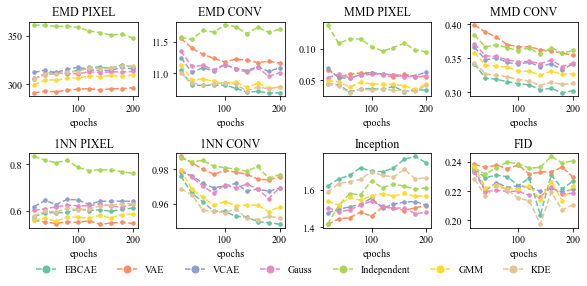

In [4]:
from matplotlib.pyplot import cm
xaxis = [i for i in range(20,201,20)]
title = ['EMD PIXEL','MMD PIXEL','1NN PIXEL','EMD CONV','MMD CONV','1NN CONV','Inception','FID']
label = ['EBCAE','VAE','VCAE','Gauss','Independent','GMM','KDE', 'RealNVP']

plt.rcParams["font.family"] = "Times New Roman"
fig=plt.figure(figsize=(8.27, 3.8))
k=1
for i in [0,3,1,4,2,5,6,7]:
    color = iter(cm.Set2(np.linspace(0, 1, 8)))
    ax = plt.subplot(2,4,k)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    for j in [0,1,2,3,4,5,6,7]:
        c = next(color)
        ax.plot(xaxis,score[:,j,i],'--bo',label=label[j], color=c,markersize=3.5)
        plt.xlabel('epochs',fontsize=10)
    ax.set_title(title[i])
    k+=1


    
lines_labels = [axi.get_legend_handles_labels() for axi in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]   


lines=[lines[0],lines[1],lines[2],lines[3],lines[4],lines[5],lines[6],lines[7]]
labels=[labels[0],labels[1],labels[2],labels[3],labels[4],labels[5],labels[6],labels[7]]

bbox_transform=fig.transFigure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),fancybox=False, markerscale=2
           ,shadow=False, framealpha=0, ncol=7, fontsize=10)


plt.tight_layout()

fig.savefig("score_CelebA_epoch_vgl_big_transposed.png",dpi=300,bbox_inches='tight')